## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Library

In [ ]:
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Reshape, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.applications import MobileNet
from sklearn.model_selection import train_test_split

## Getting Dataset

In [ ]:
# path to the dataset directory
dataset_path = "/content/drive/MyDrive/IJS/fall_dataset"


# load the training images
train_image_files = glob.glob(os.path.join(dataset_path, "images", "train") + '/*')
train_image_files.sort()

# extract the bounding box coordinates for each person in the images
train_label_files = glob.glob(os.path.join(dataset_path, "labels", "train") + '/*.txt')
train_label_files.sort()

# load the val images
val_image_files = glob.glob(os.path.join(dataset_path, "images", "val") + '/*')
val_image_files.sort()

# extract the bounding box coordinates for each person in the images
val_label_files = glob.glob(os.path.join(dataset_path, "labels", "val") + '/*.txt')
val_label_files.sort()

IMG_SIZE = (224,224) #set the image size
batch_size = 32 #set the batch number
class_name = ['Falling', 'Standing', 'Sitting']
num_class = len(class_name)
epoch = 25

# This part help in load and pair the image and label

In [ ]:
training_data = [] #for training data listing

#load and pair training image and label
for i in range(len(train_image_files)): 
    image_path = train_image_files[i] #get all image
    label_path = train_label_files[i] #get all label

    with open(label_path, "r") as f:
        for line in f.readlines():
          line = line.strip().split(" ")
          class_label = int(line[0])
          x_center, y_center, width, height = map(float, line[1:])

                
          # read the image
          img_array = cv2.imread(image_path)
          img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

          # extract the bounding box coordinates
          x_min = int((x_center - width/2) * img_array.shape[1])
          y_min = int((y_center - height/2) * img_array.shape[0])
          x_max = int((x_center + width/2) * img_array.shape[1])
          y_max = int((y_center + height/2) * img_array.shape[0])

          # crop the bounding box around the person
          person_image = img_array[y_min:y_max, x_min:x_max]

          # resize the cropped image to a fixed size and place the bounding box in the center
          person_image_resized = cv2.resize(person_image, IMG_SIZE[:2])
          person_height, person_width, _ = person_image_resized.shape
          center_x, center_y = int(person_width/2), int(person_height/2)
          x_min = center_x - int(IMG_SIZE[0]/2)
          y_min = center_y - int(IMG_SIZE[0]/2)
          x_max = center_x + int(IMG_SIZE[0]/2)
          y_max = center_y + int(IMG_SIZE[0]/2)
          cropped_image = person_image_resized[y_min:y_max, x_min:x_max]
          # add this to training_data
          training_data.append([cropped_image, class_label])

random.shuffle(training_data) #suffle training data


val_data=[] #for validation data listing

#pair validation image and label
for i in range(len(val_image_files)):
    image_path = val_image_files[i] #get all image
    label_path = val_label_files[i] #get all label

    with open(label_path, "r") as f:
        for line in f.readlines():
          line = line.strip().split(" ")
          class_label = int(line[0])
          x_center, y_center, width, height = map(float, line[1:])

                
          # read the image
          img_array = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
          img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

          # extract the bounding box coordinates
          x_min = int((x_center - width/2) * img_array.shape[1])
          y_min = int((y_center - height/2) * img_array.shape[0])
          x_max = int((x_center + width/2) * img_array.shape[1])
          y_max = int((y_center + height/2) * img_array.shape[0])

          # crop the bounding box around the person
          person_image = img_array[y_min:y_max, x_min:x_max]

          # resize the cropped image to a fixed size and place the bounding box in the center
          person_image_resized = cv2.resize(person_image, IMG_SIZE[:2])
          person_height, person_width, _ = person_image_resized.shape
          center_x, center_y = int(person_width/2), int(person_height/2)
          x_min = center_x - int(IMG_SIZE[0]/2)
          y_min = center_y - int(IMG_SIZE[0]/2)
          x_max = center_x + int(IMG_SIZE[0]/2)
          y_max = center_y + int(IMG_SIZE[0]/2)
          cropped_image = person_image_resized[y_min:y_max, x_min:x_max]

          # add this to validate_data
          val_data.append([cropped_image, class_label])

random.shuffle(val_data) #suffle validation data

Split validation data into validation and test data

In [ ]:
num_data = int(len(val_data) * 0.5)
validate_dataset = val_data[:num_data]
test_dataset = val_data[num_data:]


Separate data into image and label

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for i in range(len(training_data)):
    x_train.append(training_data[i][0])
    y_train.append(training_data[i][1])

for i in range(len(validate_dataset)):
    x_val.append(validate_dataset[i][0])
    y_val.append(validate_dataset[i][1])

for i in range(len(test_dataset)):
    x_test.append(test_dataset[i][0])
    y_test.append(test_dataset[i][1])

x_training = np.array(x_train)
y_training = y_train
x_validate = np.array(x_val)
y_validate = y_val
x_test = np.array(x_test)
y_test = y_test


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [ ]:
# normalize data
x_train = x_training.astype('float32') / 255.
x_val = x_validate.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_training, num_class)
y_val = keras.utils.to_categorical(y_validate, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

Summary for current process

In [ ]:
# summary
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

train / validation / test split: 453, 57, 57
training data shape:  (453, 224, 224, 3)
training labels shape:  (453, 3)


# Building CNN for scratch

In [ ]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_class))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

Train Model

In [ ]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    validation_data=(x_val, y_val))



Epoch 1/25
15/15 [==============================] - 15s 131ms/step - loss: 1.1110 - accuracy: 0.4150 - val_loss: 0.9939 - val_accuracy: 0.6316
Epoch 2/25
15/15 [==============================] - 1s 72ms/step - loss: 1.0753 - accuracy: 0.4724 - val_loss: 1.0013 - val_accuracy: 0.6316
Epoch 3/25
15/15 [==============================] - 1s 71ms/step - loss: 1.0642 - accuracy: 0.4746 - val_loss: 1.0586 - val_accuracy: 0.6140
Epoch 4/25
15/15 [==============================] - 1s 70ms/step - loss: 1.0433 - accuracy: 0.4989 - val_loss: 0.9930 - val_accuracy: 0.6316
Epoch 5/25
15/15 [==============================] - 1s 70ms/step - loss: 1.0457 - accuracy: 0.5121 - val_loss: 1.0445 - val_accuracy: 0.5614
Epoch 6/25
15/15 [==============================] - 1s 71ms/step - loss: 1.0069 - accuracy: 0.5188 - val_loss: 0.9482 - val_accuracy: 0.6316
Epoch 7/25
15/15 [==============================] - 1s 79ms/step - loss: 0.9594 - accuracy: 0.5408 - val_loss: 0.9555 - val_accuracy: 0.6491
Epoch 8/25


In [ ]:
# Save the model
model.save('/content/drive/MyDrive/IJS/cnn.h5')

Plot the validation loss and accuracy over epochs.

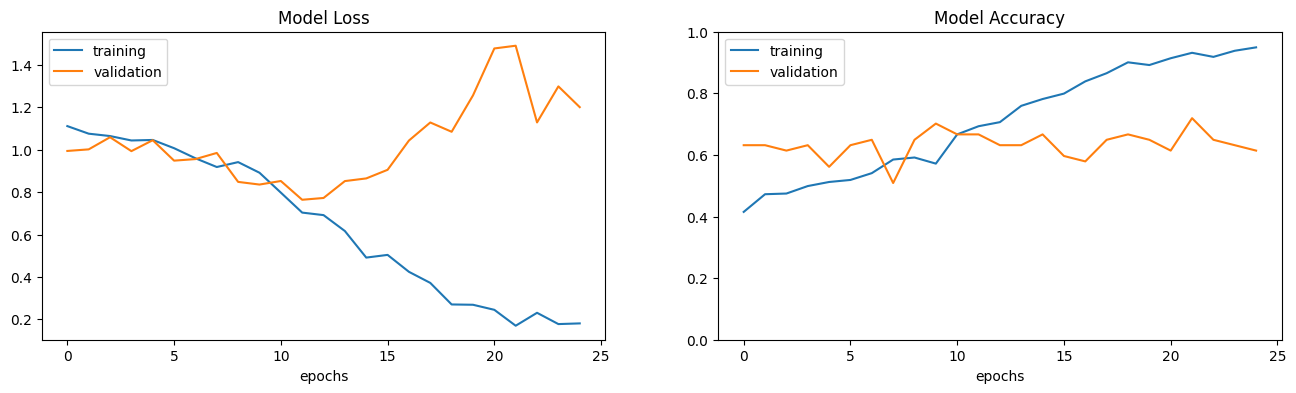

In [ ]:
fig = plt.figure(figsize=(16,4))

# plot training and validation loss
ax = fig.add_subplot(121)
ax.plot(history.history["loss"], label="training")
ax.plot(history.history["val_loss"], label="validation")
ax.set_title("Model Loss")
ax.set_xlabel("epochs")
ax.legend()

# plot training and validation accuracy
ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"], label="training")
ax2.plot(history.history["val_accuracy"], label="validation")
ax2.set_title("Model Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)
ax2.legend()

plt.show()


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.580958604812622
Test accuracy: 0.5964912176132202


2/2 [==============================] - 0s 14ms/step


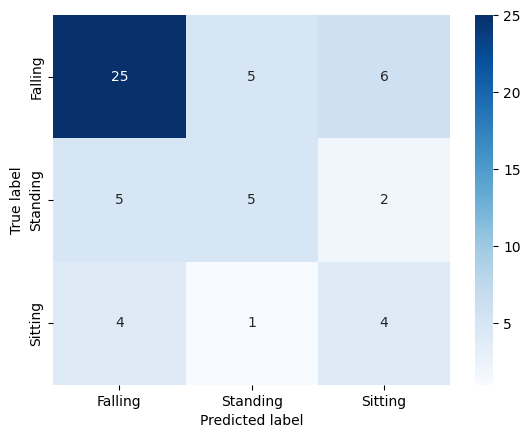

In [ ]:

# predict the classes for the test set using the trained model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# create the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## Transfer Learning

In [ ]:
# Load the MobileNet model pretrained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new Sequential model to combine the MobileNet base and additional layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Reshape((8, 8, 4)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 4)          

## Freeze the model layres

In [ ]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(x_val, y_val)
)

Epoch 1/25
15/15 [==============================] - 6s 131ms/step - loss: 0.9194 - accuracy: 0.5740 - val_loss: 0.5955 - val_accuracy: 0.7544
Epoch 2/25
15/15 [==============================] - 1s 46ms/step - loss: 0.5106 - accuracy: 0.7815 - val_loss: 0.3811 - val_accuracy: 0.7719
Epoch 3/25
15/15 [==============================] - 1s 45ms/step - loss: 0.3436 - accuracy: 0.8764 - val_loss: 0.2926 - val_accuracy: 0.9298
Epoch 4/25
15/15 [==============================] - 1s 46ms/step - loss: 0.2652 - accuracy: 0.8852 - val_loss: 0.2684 - val_accuracy: 0.9123
Epoch 5/25
15/15 [==============================] - 1s 47ms/step - loss: 0.2217 - accuracy: 0.9139 - val_loss: 0.3291 - val_accuracy: 0.8421
Epoch 6/25
15/15 [==============================] - 1s 45ms/step - loss: 0.1352 - accuracy: 0.9448 - val_loss: 0.3200 - val_accuracy: 0.9298
Epoch 7/25
15/15 [==============================] - 1s 46ms/step - loss: 0.1462 - accuracy: 0.9272 - val_loss: 0.2894 - val_accuracy: 0.9298
Epoch 8/25
1

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/IJS/transfer.h5')

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.623613178730011
Test accuracy: 0.8771929740905762


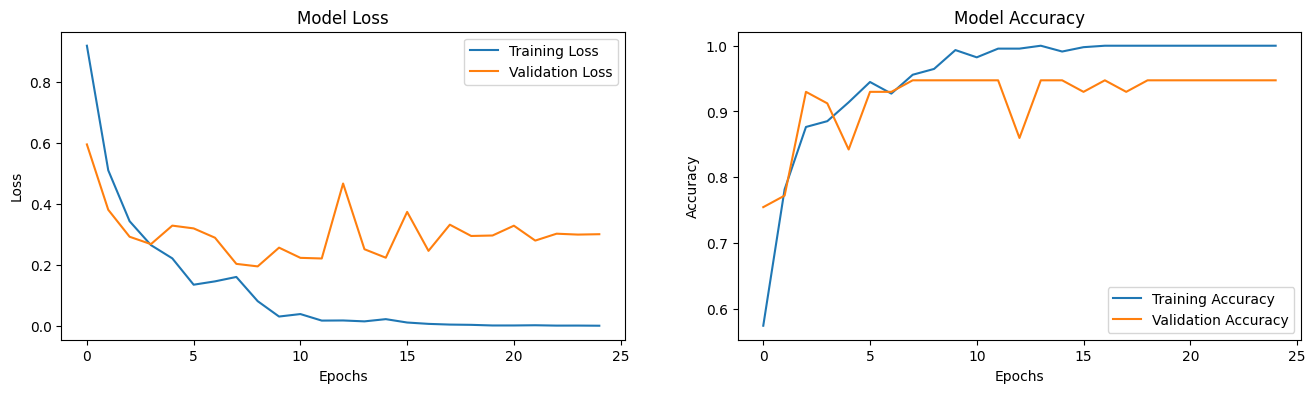

In [ ]:
fig = plt.figure(figsize=(16,4))
# Plot the training and validation loss over epochs
ax = fig.add_subplot(121)
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title("Model Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

# Plot the training and validation accuracy over epochs
ax2 = fig.add_subplot(122)
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Model Accuracy")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()



2/2 [==============================] - 1s 43ms/step


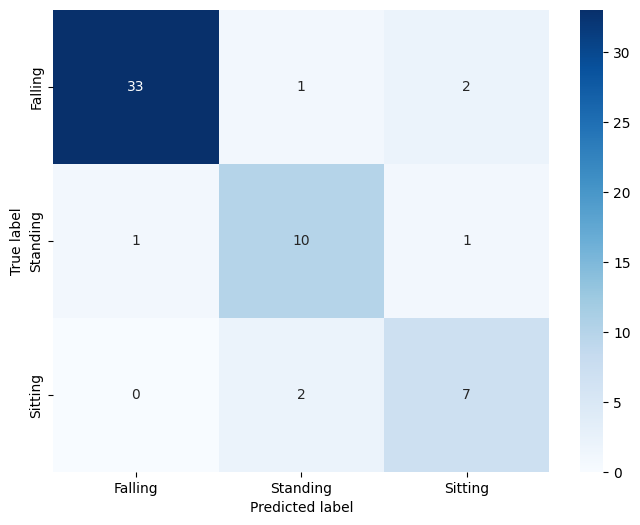

In [ ]:
# predict the classes for the test set using the trained model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# create the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# plot the confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



## Unfreeze model layer

In [ ]:
# Unfreeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(x_val, y_val)
)

Epoch 1/25
15/15 [==============================] - 23s 226ms/step - loss: 1.2183 - accuracy: 0.7616 - val_loss: 3.9645 - val_accuracy: 0.2456
Epoch 2/25
15/15 [==============================] - 2s 117ms/step - loss: 0.3221 - accuracy: 0.8786 - val_loss: 4.7951 - val_accuracy: 0.1754
Epoch 3/25
15/15 [==============================] - 2s 114ms/step - loss: 0.1331 - accuracy: 0.9536 - val_loss: 5.3252 - val_accuracy: 0.1754
Epoch 4/25
15/15 [==============================] - 2s 112ms/step - loss: 0.0804 - accuracy: 0.9801 - val_loss: 5.4644 - val_accuracy: 0.1754
Epoch 5/25
15/15 [==============================] - 2s 118ms/step - loss: 0.1476 - accuracy: 0.9470 - val_loss: 2.6987 - val_accuracy: 0.4211
Epoch 6/25
15/15 [==============================] - 2s 119ms/step - loss: 0.0893 - accuracy: 0.9713 - val_loss: 0.7953 - val_accuracy: 0.8596
Epoch 7/25
15/15 [==============================] - 2s 113ms/step - loss: 0.3910 - accuracy: 0.9294 - val_loss: 0.2711 - val_accuracy: 0.8596
Epoch

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/IJS/transfer(x).h5')

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.0880365371704102
Test accuracy: 0.7894737124443054


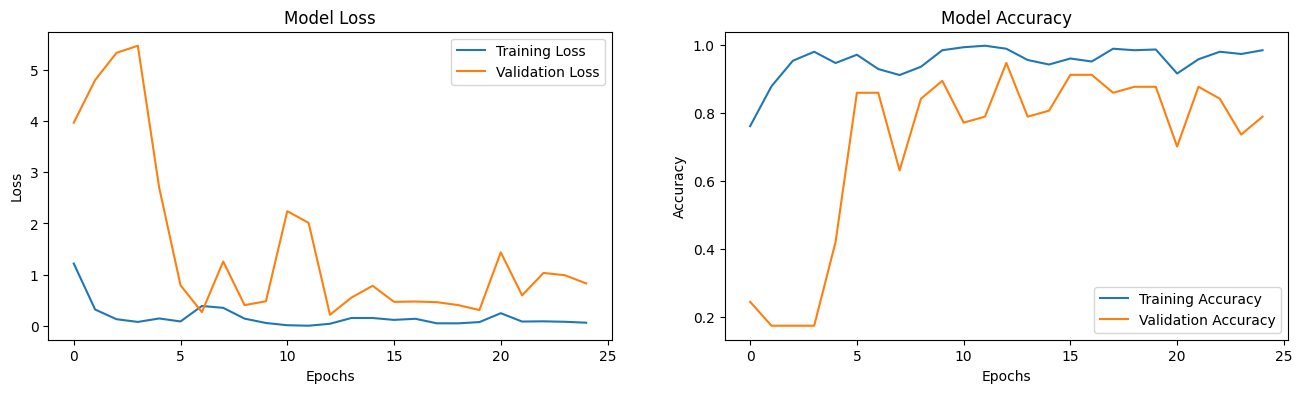

In [ ]:
# Plot the training and validation loss over epochs
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(121)
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title("Model Loss")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

# Plot the training and validation accuracy over epochs
ax2 = fig.add_subplot(122)
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Model Accuracy")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

2/2 [==============================] - 1s 43ms/step


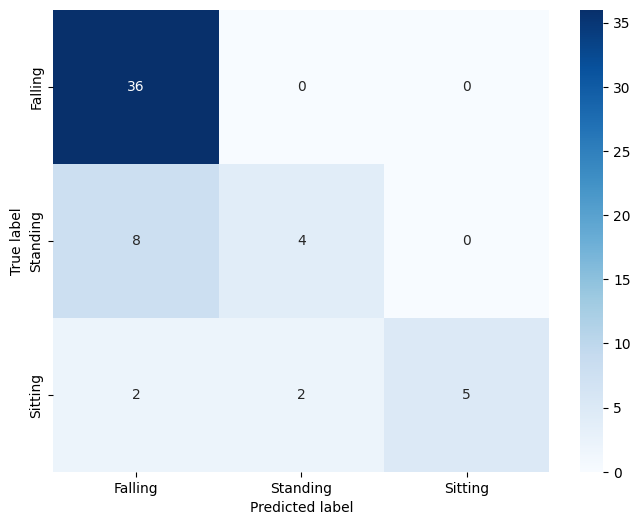

In [ ]:
# predict the classes for the test set using the trained model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# create the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# plot the confusion matrix as a heatmap with class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()